<span style="color:red;font-size:1.5em;font-weight:bold;background-color:yellow">Partie 4 - Appliquer la méthode supervisée</span>

<span style="color:orange;font-size:1.5em;font-weight:bold">Cas cluster + semi supervisé</span>

<span style="color:blue;font-size:1.2em;font-weight:bold">Mise en place</span>

In [1]:
# Module pour recharger un module sans redemarrer le kernel
# import importlib
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import numpy as np
import pandas as pd
from pathlib import Path
import gc
import copy

# On utilise pytorch ici plutot que tensorflow
# Avantage: plus personnalisable VS Plus facile a utiliser 
# Définit les tenseurs, couches de neurones et algo d'opti (SGD,Adam)
import torch
import torch.nn as nn
import torch.optim as optim
# Pour créer une structure pour lire les images et les envoyer par paquet (batches) au GPU
from torch.utils.data import DataLoader
# Contient des architectures pré-entraînées (ResNet, VGG).

from sklearn.model_selection import train_test_split



In [3]:
# Sert à éviter les Warnings avec les transformations sur des vues en transformant 
# ces warning en erreur obligeant ainsi à ne travailler que sur des copies ou les originaux.

pd.set_option('mode.chained_assignment','raise')

In [4]:
# Ajoute le dossier datas_manipulation au sys.path. Remarque ne pas oublier le __init__.py dans le dossier datas_manipulation
import sys
# root_path = Path(__file__).resolve().parents[1] # Ne fonctionne pas sur notebook
ROOT_PATH = Path.cwd().parent
sys.path.append(str(ROOT_PATH))

In [5]:
# Fonctions personnelles

from notebooks.utils.dataset import BaseTransform, ImagesToDataset
from notebooks.utils.models import BrainCancerClassifier
from notebooks.utils.training import Trainer, SslManager
from notebooks.utils.data_manipulation import get_score
from notebooks.utils.plotting.make_model_plots import plot_confusion_matrix


In [6]:
# Variables/paramètres globales

# Création dossier results
SAVE_PATH = ROOT_PATH.joinpath('datas/results')
Path.mkdir(SAVE_PATH,exist_ok = True)

# Pour la reproductibilité (similaire a random_state) 
# --> influence l'initialisation des poids ResNet et le mélange du DataLoader
torch.manual_seed(42)
np.random.seed(42)

# Config pour basculer sur le GPU si possible (50x plus rapide en deep learning que CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {DEVICE}")
# Taille des paquets (en puissance de 2 pour s'aligner avec l'archi GPU: 2 4 8 16 32 64)
BATCH_SIZE = 16

# Config des images
IMG_SIZE = 224 # Résolution standard 
# Cas transfer learning avec ResNet: Les valeurs données sont les moyennes et ecarts type des 
# couleurs RGB dans ImageNet
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

RANDOM_STATE=42
N_JOBS=-1
# N_FEATURES = 512 # Nombre de features issu des CNN,en 18,34 couches on a 512 features, 
# # en 50,101 et 152 on passe a 2048 features, avec VGG16 on est 4096 
# # et pour EfficientNet-BO c'est 1280 features
TEST_SIZE = 0.2
N_EPOCH = 10
EXPERIMENT_NAME = "experiment_01"

Running on: cpu


In [7]:
# Dictionnaire de la confinguration globale du projet
project_config = {
    "model":"resnet18",
    # "n_features":N_FEATURES,
    "n_jobs":N_JOBS,
    "batch":BATCH_SIZE,
    "device":str(DEVICE),
    "img_size":IMG_SIZE,
    "img_mean":IMG_MEAN,
    "img_std":IMG_STD,
    "test_size":TEST_SIZE,
    "random_state":RANDOM_STATE,
}

In [8]:
# Chemin des données brutes
DATAS_PATH = ROOT_PATH/"datas/raw/mri_dataset_brain_cancer_oc"

# Listing des fichiers qui composent les labellisés des non labellisés
# glob pour les fichiers et rglob si il y a des sous-dossiers
avec_labels_path = list((DATAS_PATH / "avec_labels").rglob("*.jpg"))
sans_label_path = list((DATAS_PATH / "sans_label").glob("*.jpg"))
project_config.update({"avec_label":len(avec_labels_path),"sans_label":len(sans_label_path)})

# Encodage des labels (0: normal, 1: cancer, -1: sans_label)
avec_labels_encoding = [1 if "cancer" in path.parts else 0 for path in avec_labels_path]
all_paths = avec_labels_path + sans_label_path
all_labels = avec_labels_encoding + ([-1] * len(sans_label_path))


<span style="color:blue;font-size:1.5em;font-weight:bold;background-color:yellow">Entrainement Semi Supervisée: Pseudo labelling sur les images inconnues</span>

**On a donc vu dans un premier temps que la non supervision entrainait des résultats médiocres dans un premier temps notamment car le CNN **

C'est là qu'intervient la semi-supervision et on va pour cela utiliser le pseudo labelling. Son algorithme est le suivant:

- Prédire sur les données non labellisées .
- Sélectionner les prédictions où le modèle est le plus confiant (au-dessus d'un certain seuil).
- Ajouter ces prédictions (images + pseudo-labels) au jeu d'entraînement étiqueté.
- Ré-entraîner le modèle sur ce nouveau jeu de données augmenté.
- Répéter !

On va ici partir du clustering et regarder si le processus de pseudo labelling va améliorer les résultats ou non.

In [9]:
# gestionnaire de sauvegarde
ssl_with_cluster_manager = SslManager(
    EXPERIMENT_NAME,
    root_path=SAVE_PATH,
    extension_path="ssl_with_cluster"
)

<span style="color:blue;font-size:1.2em;font-weight:bold">Chargement des résultats du clustering</span>

<span style="color:purple;font-weight:bold">Configuration</span>

On va partir du résultats du cas **pca-kmeans** précédent qui va servir "d'initialisation"

In [10]:
# on charge la donnée (issu de analyzer du non supervisé)
df_cluster = pd.read_parquet(SAVE_PATH/"unsupervised"/EXPERIMENT_NAME/"df_cluster.parquet")

In [11]:
ssl_with_cluster_config = project_config | {
    "reset":True,
    "max_pseudo_iter":10,
    "ssl_with_cluster_learning_rate":1e-5,
    "init_threshold":0.95,
    "final_threshold":0.85,
    'ssl_with_cluster_n_epoch':N_EPOCH*2,
    
}

ssl_with_cluster_manager.save_config(ssl_with_cluster_config)


# Instanciation de l'objet de redim, norm, augmentation
base_transform = BaseTransform(mean=IMG_MEAN,std=IMG_STD,size=IMG_SIZE)

In [12]:
# Remise en place du LOADER DE VALIDATION (SET DE VALIDATION)

# juste par confort
X = avec_labels_path
y = avec_labels_encoding

# Train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=TEST_SIZE, 
    stratify=y, 
    random_state=RANDOM_STATE
)

# Set de validation
test_dataset = ImagesToDataset(X_test, y_test, transform=base_transform.preproc(train=False))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

<span style="color:purple;font-weight:bold">Phase d'initialisation</span>

In [13]:
# dataset et dataloader d'initialisation (la composition supposée par le cluster)

# On s'assure de ne prendre que ce qui a été labelliser (fort et faible) sur le jeu
df_init = df_cluster[df_cluster['cluster_pseudo_label'] != -1]

X_init = [Path(p) for p in df_init['path'].tolist()]
y_init = df_init['cluster_pseudo_label'].astype(int).tolist()

idataset = ImagesToDataset(
    X_init, 
    y_init, 
    transform=base_transform.preproc(train=True, strong_augment=True)
)
iloader = DataLoader(idataset, batch_size=BATCH_SIZE, shuffle=True)

**Rappel**: pca_kmeans etc... sont les groupements brutes des algo de clustering

In [14]:
# Me^me pre traitement sur les données non labellisées (pas de split ni d'augment evidemment)
Xu = sans_label_path
yu = [-1]*len(sans_label_path)
# dataset et loader
udataset = ImagesToDataset(Xu, yu, transform=base_transform.preproc(train=False))
uloader = DataLoader(udataset, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
# Instanciation du classificateur + déplacement sur le device
model_classif = BrainCancerClassifier(
    num_classes=1, 
    model_name=ssl_with_cluster_config['model']
).to(DEVICE)
# L'optimiseur ajuste les poids du modèle. Contient le learning_rate et les gradients.
# On met un learning rate (lr) faible car fine-tuning 
# (on ne veut pas détruire ce que ResNet sait déjà).
optimizer = optim.Adam(
    model_classif.parameters(), 
    lr=ssl_with_cluster_config["ssl_with_cluster_learning_rate"]
)
# On instancie la loss suivant le set de clustering
num_sains = y_init.count(0)
num_cancers = y_init.count(1)
# Calcul du ratio (poids pour la classe positive)
# On ajoute 1e-6 pour éviter la division par zéro si le modèle ne trouve aucun cancer
pos_weight = torch.tensor([num_sains / (num_cancers + 1e-6)]).to(DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Instanciation de la pipeline de training
trainer = Trainer(
    model_classif, 
    DEVICE, 
    criterion, 
    optimizer
)

In [16]:
# Boucle d'entraînement
temp_best_f2 = 0.0
temp_best_prauc = 0.0
temp_best_ece = 1.0
temp_best_score = get_score(temp_best_f2,temp_best_ece,temp_best_prauc,mode = "cluster")

print(f" Initialisation d'entraînement sur le set issu du cluster ({len(X_init)} images)")
for epoch in range(ssl_with_cluster_config['ssl_with_cluster_n_epoch']):
    # ================= ENTRAINEMENT ================
    train_loss = trainer.train_epoch(iloader)
    # ====================== EVAL =====================
    results = trainer.eval_metrics(test_loader) # on evalue sur les 20 images restantes label
    ece = trainer.calculate_ece(results['raw_data']) #type:ignore On estime la fiabilité de la confiance
    print(
        f"Epoch {epoch+1}/{ssl_with_cluster_config['ssl_with_cluster_n_epoch']} | Loss: {train_loss:.4f}"
        f" | f2: {results["f2"]:.4f} | pr_auc: {results["pr_auc"]:.4f} | ece: {ece:.4f}"
    )
    # ================= SAUVEGARDE INDIVIDUELLE DES MÉTRIQUES =============
    temp_metrics ={
            "epoch" : epoch+1,
            "train_loss" : train_loss,
            # "f2" : results["f2"],
            # "precision" : results["precision"],
            # "recall":results["recall"],
            "ece":ece, # Fiabilité de la confiance du modèle
            # "accuracy": results["accuracy"], # Exactitude
            # "auc": results["auc"],# Capacité a séparer les labels
            # "pr_auc": results["pr_auc"], # Précision sur les positifs
            **{key: value for key, value in results.items()}
        }
    ssl_with_cluster_manager.log_metrics(temp_metrics)
    
    # ================ CHECKPOINT (SAVE SI MEILLEUR MODELE JUSQU'ICI) ===========
    temp_f2 = results["f2"]
    temp_prauc = results['pr_auc']
    temp_score = get_score(temp_f2,ece,temp_prauc,mode = "cluster")
    
    if temp_score >= temp_best_score:
    # if (temp_prauc >= temp_best_prauc) or (temp_f2 >= temp_best_f2):
    #     if ece <= temp_best_ece*1.25:
            # réalise un checkpoint suivant la condition f2 (sauvegarde comme best ou pas)
        ssl_with_cluster_manager.save_checkpoint({
            'epoch': epoch + 1,
            'train_loss':train_loss,
            'state_dict': model_classif.state_dict(), # ou plus rigoureux: trainer.model.state_dict()
            'optimizer': optimizer.state_dict(),# ou plus rigoureux: trainer.optimizer.state_dict()
            'f2': temp_f2,
            'pr_auc': temp_prauc,
            'ece':ece,
            'config': ssl_with_cluster_config
        },is_best=True)
        
        # MAJ des métriques
        # temp_best_f2 = max(temp_f2, temp_best_f2)
        temp_best_f2 = temp_f2
        temp_best_prauc = temp_prauc
        temp_best_ece = ece
        temp_best_score = temp_score

 Initialisation d'entraînement sur le set issu du cluster (1506 images)
Epoch 1/20 | Loss: 0.6119 | f2: 0.6522 | pr_auc: 0.8844 | ece: 0.2174
Epoch 2/20 | Loss: 0.5645 | f2: 0.6522 | pr_auc: 0.9169 | ece: 0.2190
Epoch 3/20 | Loss: 0.5187 | f2: 0.6522 | pr_auc: 0.9007 | ece: 0.2990
Epoch 4/20 | Loss: 0.4779 | f2: 0.6522 | pr_auc: 0.9248 | ece: 0.1967
Epoch 5/20 | Loss: 0.4530 | f2: 0.6522 | pr_auc: 0.9248 | ece: 0.1632
Epoch 6/20 | Loss: 0.4245 | f2: 0.6522 | pr_auc: 0.9248 | ece: 0.1839
Epoch 7/20 | Loss: 0.4107 | f2: 0.6522 | pr_auc: 0.9219 | ece: 0.1611
Epoch 8/20 | Loss: 0.3872 | f2: 0.6522 | pr_auc: 0.9219 | ece: 0.1497
Epoch 9/20 | Loss: 0.3824 | f2: 0.6522 | pr_auc: 0.9219 | ece: 0.1463
Epoch 10/20 | Loss: 0.3744 | f2: 0.6522 | pr_auc: 0.9248 | ece: 0.1945
Epoch 11/20 | Loss: 0.3674 | f2: 0.6522 | pr_auc: 0.9281 | ece: 0.1463
Epoch 12/20 | Loss: 0.3560 | f2: 0.6522 | pr_auc: 0.9248 | ece: 0.1346
Epoch 13/20 | Loss: 0.3488 | f2: 0.6522 | pr_auc: 0.9248 | ece: 0.1363
Epoch 14/20 | 

In [17]:
# ============== MEILLEUR MODELE POUR AFFICHAGE METRIQUES ===========
# On recharge le meilleur état trouvé pour la suite (SSL)
model_path = ssl_with_cluster_manager.ckpt_dir / "best_model.pth"
checkpoint = torch.load(model_path, weights_only=False)
model_classif.load_state_dict(checkpoint['state_dict'])
print(f"Meilleur modèle chargé - epoch: {checkpoint['epoch']} | f2: {checkpoint['f2']:.4f}"
    f"| pr_auc: {checkpoint['pr_auc']:.4f} | ece: {checkpoint['ece']:.4f}")

# Evaluation finale
ssl_with_cluster_metrics = trainer.eval_metrics(test_loader)
phase_init = pd.DataFrame([ssl_with_cluster_metrics])
display(phase_init)

Meilleur modèle chargé - epoch: 12 | f2: 0.6522| pr_auc: 0.9248 | ece: 0.1346


,f2,precision,recall,accuracy,auc,pr_auc,confusion_matrix,raw_data,ssl_stats
0,0.652174,1.0,0.6,0.8,0.88,0.924786,"{'tn': 10, 'fp': 0, 'fn': 4, 'tp': 6}","{'probs': [0.8933255076408386, 0.7554250359535...","{'precision_at_thresh': 0.0, 'count_above_thre..."


Cette première itération à partir du set de clustering a grandement amélioré les scores biens qu'ils restent relativement moyen (f2 autour de 0.6 et ece autour de 0.15).

In [18]:
# =============== NETTOYAGE ===============
del (test_dataset,
    train_loss, results
)
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

<span style="color:purple;font-weight:bold">Phase SSL</span>

In [19]:
# La mise en place globale du pseudo labelling
max_pseudo_iteration = ssl_with_cluster_config['max_pseudo_iter']
reset = True # Si on repart d'une pipeline neuve (Cold start) ou pas (Continous Fine Tuning)
# Cold start permet d'eviter l'accumulation d'erreurs et l'oubli (stacker les biais et 
# oublier les fortement labellisés) MAIS coût d'entrainement plus elevé

# Garde fou pour éviter dérive
max_stop = 3

# # décroissance du threshold, on assoupli le threshold a mesure des iterations
decay = np.linspace(
    ssl_with_cluster_config["init_threshold"],
    ssl_with_cluster_config["final_threshold"],
    max_pseudo_iteration+1
)

In [20]:
counter = 0
stop = 0
temp_best_f2 = checkpoint['f2'] # On repart du f2 de la baseline (supervisée)
temp_best_prauc = checkpoint['pr_auc'] # On repart de l'aucpr de la baseline (supervisée)
temp_best_ece = checkpoint['ece']
temp_best_score = get_score(temp_best_f2,temp_best_ece, temp_best_prauc)
best_trainer_state = copy.deepcopy(trainer.model.state_dict())
ece = checkpoint['ece']

del checkpoint
gc.collect()

while counter <= max_pseudo_iteration:
    # On s'assure que le threshold est bon
    trainer.threshold = decay[counter]
    
    # ======== PRÉDICTION SUR SET INCONNU ET GET DES PSEUDO LABELS/PATHS =========
    # IMPORTANT: AVANT D'ETRE ECRASE, ON RECOLTE PSEUDO_X ET Y! CE N'EST PAS ULOADER QUI DOIT
    # ETRE MAJ MAIS TRAINER QUI SERA MODIFIE (NOUVEAU PSEUDO_X ET PSEUDO_Y) AVANT SON RESET.
    # MODEL_CLASSIF ET OPTIMIZER DE LA PARTIE SUPERVISÉE ONT POUR SEULE UTILITÉ INFLUENCÉ TRAINER
    print(f"=== iter {counter} | pseudo labelling (seuil {decay[counter]:.4f}) ===")
    pseudo_X, pseudo_y = trainer.pseudo_labels(uloader)
    print(f"Pseudo-labels générés : {len(pseudo_X)}")
    
    # ============= EMPECHE BOUCLE INUTIE ET DERIVE IMPORTANTE =================
    if len(pseudo_X) == 0 or ece >= 0.5: #type:ignore  Ajout de l'ece pour eviter le biais de confirmation
        print("Confiance rompue pour relancer l'entrainement")
        break
    
    
    # ========== MISE EN PLACE DU DATALOADER ================ 
    # (On NE STACK PAS les pseudo et on REPART TOUJOURS du jeu labellisé de base!)
    new_X_train = X_train + [Path(x) for x in pseudo_X]
    new_y_train = y_train + pseudo_y
    
    # dataset et loader, on applique des transformations et shuffle. Pour corser le travail et
    # rendre l'entrainement plus efficace, on applique ici des transformations FORTES VS FAIBLE
    # pour le train du supervisée
    new_train_dataset = ImagesToDataset(
        new_X_train,
        new_y_train,
        transform=base_transform.preproc(train=True,strong_augment=True)
    )
    new_train_loader = DataLoader(
        new_train_dataset,
        BATCH_SIZE,
        shuffle=True
    )
    
    # =================== REGUL PONDERATION DU CRITERION =================
    # Si les pseudo labels déséquilibrent trop le jeu d'entrainement, il faut reponderer criterion
    # Compter les occurrences dans le nouveau set d'entraînement
    num_sains = new_y_train.count(0)
    num_cancers = new_y_train.count(1)
    # Calcul du ratio (poids pour la classe positive)
    # On ajoute 1e-6 pour éviter la division par zéro si le modèle ne trouve aucun cancer
    new_pos_weight = torch.tensor([num_sains / (num_cancers + 1e-6)]).to(DEVICE)
    new_criterion = nn.BCEWithLogitsLoss(pos_weight=new_pos_weight)
    
    # ================ MISE EN PLACE DU TRAINER =========================
    if reset:
        # ============ COLD START ==============
        # NEW START, on repart d'un nouveau modele et nouvel optimiseur (et entrainement)
        # ========================= Cleaning ================
        if 'new_trainer' in locals():
            del new_model_classif, new_optimizer, new_trainer
            gc.collect() # Libère la RAM CPU
            if torch.cuda.is_available():
                torch.cuda.empty_cache() # Libère la VRAM GPU
        # =========================================
        # CHARGEMENT DES POIDS DU MEILLEUR MODÈLE PRÉCÉDENT
        new_model_classif = BrainCancerClassifier(
            num_classes=1,
            model_name=ssl_with_cluster_config['model']
        ).to(DEVICE)
        new_model_classif.load_state_dict(copy.deepcopy(best_trainer_state))
        
        new_optimizer = optim.Adam(
            new_model_classif.parameters(), 
            lr=ssl_with_cluster_config["ssl_with_cluster_learning_rate"]
        )
        # new_criterion = nn.BCELoss() # Avec SIGMOID on prefere passer a logit + label smoothing
        new_trainer = Trainer(
            new_model_classif, 
            DEVICE, 
            new_criterion, 
            new_optimizer, 
            threshold=decay[counter]
        )
    else:
        # ============ CONTNOUS FINE TUNING ============
        # ON GARDE LE MEME TRAINER, REDUCTION SEUIL + LEARNING_RATE pour ne pas détruire 
        # les poids déjà appris.
        new_trainer = trainer
        new_trainer.threshold = decay[counter] # MAJ threshold
        new_trainer.criterion.pos_weight = new_pos_weight # MAJ Pondération
        # La boucle est obligatoire pour modifier le LR dans PyTorch
        for param_group in new_trainer.optimizer.param_groups:
            param_group['lr'] = ssl_with_cluster_config["ssl_with_cluster_learning_rate"] / 10
    
    # =============== ENTRAINEMENT ====================================
    IMPROVED_FLAG = False
    print(f"====== iter {counter} | seuil {decay[counter]:.4f} | {len(new_X_train)} images =======")
    for epoch in range(ssl_with_cluster_config['ssl_with_cluster_n_epoch']):
        train_loss = new_trainer.train_epoch(new_train_loader) # le nouveau set de train
        # ====================== EVAL =====================
        results = new_trainer.eval_metrics(test_loader) # ON RESTE SUR LE MEME SET D'EVAL!
        ece = new_trainer.calculate_ece(results['raw_data'])# type:ignore
        print(f"Epoch {epoch+1}/{ssl_with_cluster_config['ssl_with_cluster_n_epoch']} | Loss: {train_loss:.4f} | f2: {results["f2"]:.4f} | pr_auc: {results["pr_auc"]:.4f} | ece: {ece:.4f}")
        # =============== CHECKPOINT =====================================
        temp_metrics = {
            "epoch":epoch+1,
            "iteration":counter,
            "threshold":decay[counter],
            "n_pseudo":len(pseudo_X),
            "train_loss":train_loss,
            "ece":ece, # Fiabilité de la confiance du modèle
            **{key: value for key, value in results.items()}
        }
        ssl_with_cluster_manager.log_metrics(temp_metrics)
        
        temp_f2 = results['f2']
        temp_prauc = results['pr_auc']
        temp_score = get_score(temp_f2,ece,temp_prauc)

        if temp_score > temp_best_score:
        # if (temp_prauc >= temp_best_prauc) or (temp_f2 >= temp_best_f2):
        #     if temp_ece <= temp_best_ece:
                
            # On sauvegarde l'état du modèle et les pseudos qui ont fonctionné
            # best_trainer_state = copy.deepcopy(new_trainer.model.state_dict())
            # Moins gourmand en RAM
            best_trainer_state = {
                key: value.cpu().clone() for key, value 
                in new_trainer.model.state_dict().items()
            }
            temp_best_f2 = temp_f2
            # QUE pour le checkpoint!
            temp_best_prauc = temp_prauc
            IMPROVED_FLAG = True
            temp_best_ece = ece
            temp_best_score = temp_score
            
            temp_state = {
                'epoch':epoch+1,
                'iteration':counter,
                'threshold':decay[counter],
                'n_pseudo':len(pseudo_X),
                'train_loss':train_loss,
                'confusion_matrix':temp_metrics['confusion_matrix'],
                # new_model_classif.state_dict() == new_trainer.model.state_dict() 
                # donc on peut raccourcir ici car pointent au même objet en mémoire
                'state_dict': new_model_classif.state_dict(), 
                # new_optimizer.state_dict(), si pas de cold start: plante car n'existe pas
                'optimizer': new_trainer.optimizer.state_dict(),
                'f2': temp_best_f2,
                'pr_auc': temp_best_prauc,
                'ece':temp_best_ece,
                'config': ssl_with_cluster_config
            }
            ssl_with_cluster_manager.save_checkpoint(temp_state, is_best=True)
            ssl_with_cluster_manager.save_weak_labels(pseudo_X, pseudo_y)
                
    if not IMPROVED_FLAG: # On a fait la boucle d'entrainement mais pas d'amélioration sur l'iteration
        # ============= CAS LAMBDA =============
        # Rollback : on recharge les poids du meilleur modèle dans le trainer actuel
        new_trainer.model.load_state_dict(best_trainer_state)
        stop+=1
    else:
        stop = 0 # on reinitialise le compteur de stagnation
    if stop >= max_stop:
        print('Arrêt prématuré, plus de progression')
        break
    
    trainer = new_trainer
    counter+=1
    
    # ========================= Cleaning ================
    # Nettoyage de fin d'itération
    del new_train_loader
    gc.collect()
    if torch.cuda.is_available():
            torch.cuda.empty_cache() # Libère la VRAM GPU
# =========================================

=== iter 0 | pseudo labelling (seuil 0.9500) ===


Pseudo-labeling: 100%|██████████| 88/88 [01:15<00:00,  1.16it/s]


Pseudo-labels générés : 2
====== iter 0 | seuil 0.9500 | 82 images =======
Epoch 1/20 | Loss: 0.5268 | f2: 0.7447 | pr_auc: 0.9198 | ece: 0.2234
Epoch 2/20 | Loss: 0.4934 | f2: 0.7447 | pr_auc: 0.9406 | ece: 0.1504
Epoch 3/20 | Loss: 0.5091 | f2: 0.7447 | pr_auc: 0.9567 | ece: 0.1793
Epoch 4/20 | Loss: 0.5251 | f2: 0.7447 | pr_auc: 0.9488 | ece: 0.1408
Epoch 5/20 | Loss: 0.4965 | f2: 0.7447 | pr_auc: 0.9374 | ece: 0.1385
Epoch 6/20 | Loss: 0.5106 | f2: 0.7447 | pr_auc: 0.9317 | ece: 0.1204
Epoch 7/20 | Loss: 0.5242 | f2: 0.7447 | pr_auc: 0.9443 | ece: 0.1363
Epoch 8/20 | Loss: 0.4984 | f2: 0.7447 | pr_auc: 0.9588 | ece: 0.1655
Epoch 9/20 | Loss: 0.4565 | f2: 0.7447 | pr_auc: 0.9488 | ece: 0.1417
Epoch 10/20 | Loss: 0.4763 | f2: 0.7447 | pr_auc: 0.9406 | ece: 0.1393
Epoch 11/20 | Loss: 0.4402 | f2: 0.7447 | pr_auc: 0.9374 | ece: 0.1413
Epoch 12/20 | Loss: 0.5028 | f2: 0.7447 | pr_auc: 0.9488 | ece: 0.1646
Epoch 13/20 | Loss: 0.4292 | f2: 0.7447 | pr_auc: 0.9306 | ece: 0.1708
Epoch 14/20

Pseudo-labeling: 100%|██████████| 88/88 [01:15<00:00,  1.16it/s]


Pseudo-labels générés : 13
====== iter 1 | seuil 0.9400 | 93 images =======
Epoch 1/20 | Loss: 0.4330 | f2: 0.7447 | pr_auc: 0.9567 | ece: 0.1127
Epoch 2/20 | Loss: 0.4084 | f2: 0.7447 | pr_auc: 0.9443 | ece: 0.1129
Epoch 3/20 | Loss: 0.3896 | f2: 0.7447 | pr_auc: 0.9525 | ece: 0.1296
Epoch 4/20 | Loss: 0.3999 | f2: 0.7447 | pr_auc: 0.9488 | ece: 0.1305
Epoch 5/20 | Loss: 0.4192 | f2: 0.7447 | pr_auc: 0.9406 | ece: 0.1151
Epoch 6/20 | Loss: 0.3713 | f2: 0.7447 | pr_auc: 0.9488 | ece: 0.1165
Epoch 7/20 | Loss: 0.3861 | f2: 0.7447 | pr_auc: 0.9488 | ece: 0.1092
Epoch 8/20 | Loss: 0.3905 | f2: 0.7447 | pr_auc: 0.9525 | ece: 0.1284
Epoch 9/20 | Loss: 0.4145 | f2: 0.7447 | pr_auc: 0.9488 | ece: 0.1134
Epoch 10/20 | Loss: 0.4095 | f2: 0.7447 | pr_auc: 0.9488 | ece: 0.1105
Epoch 11/20 | Loss: 0.4084 | f2: 0.7447 | pr_auc: 0.9567 | ece: 0.1291
Epoch 12/20 | Loss: 0.3860 | f2: 0.7447 | pr_auc: 0.9488 | ece: 0.1101
Epoch 13/20 | Loss: 0.4090 | f2: 0.7447 | pr_auc: 0.9488 | ece: 0.1108
Epoch 14/2

Pseudo-labeling: 100%|██████████| 88/88 [01:16<00:00,  1.15it/s]


Pseudo-labels générés : 42
====== iter 2 | seuil 0.9300 | 122 images =======
Epoch 1/20 | Loss: 0.3491 | f2: 0.7447 | pr_auc: 0.9374 | ece: 0.1316
Epoch 2/20 | Loss: 0.3606 | f2: 0.7447 | pr_auc: 0.9456 | ece: 0.1931
Epoch 3/20 | Loss: 0.3224 | f2: 0.7447 | pr_auc: 0.9456 | ece: 0.2054
Epoch 4/20 | Loss: 0.3092 | f2: 0.7447 | pr_auc: 0.9456 | ece: 0.2006
Epoch 5/20 | Loss: 0.3542 | f2: 0.7447 | pr_auc: 0.9374 | ece: 0.1965
Epoch 6/20 | Loss: 0.3298 | f2: 0.7447 | pr_auc: 0.9456 | ece: 0.1956
Epoch 7/20 | Loss: 0.3324 | f2: 0.7447 | pr_auc: 0.9456 | ece: 0.2190
Epoch 8/20 | Loss: 0.3181 | f2: 0.7447 | pr_auc: 0.9456 | ece: 0.2034
Epoch 9/20 | Loss: 0.3170 | f2: 0.7447 | pr_auc: 0.9456 | ece: 0.1805
Epoch 10/20 | Loss: 0.3429 | f2: 0.7447 | pr_auc: 0.9456 | ece: 0.1430
Epoch 11/20 | Loss: 0.3063 | f2: 0.7447 | pr_auc: 0.9456 | ece: 0.2073
Epoch 12/20 | Loss: 0.3269 | f2: 0.7447 | pr_auc: 0.9456 | ece: 0.1848
Epoch 13/20 | Loss: 0.3161 | f2: 0.7447 | pr_auc: 0.9556 | ece: 0.1584
Epoch 14/

Pseudo-labeling: 100%|██████████| 88/88 [01:15<00:00,  1.17it/s]


Pseudo-labels générés : 96
====== iter 3 | seuil 0.9200 | 176 images =======
Epoch 1/20 | Loss: 0.2329 | f2: 0.7447 | pr_auc: 0.9374 | ece: 0.1358
Epoch 2/20 | Loss: 0.2257 | f2: 0.6522 | pr_auc: 0.9374 | ece: 0.1417
Epoch 3/20 | Loss: 0.2350 | f2: 0.6522 | pr_auc: 0.9344 | ece: 0.1470
Epoch 4/20 | Loss: 0.2280 | f2: 0.6522 | pr_auc: 0.9344 | ece: 0.1434
Epoch 5/20 | Loss: 0.2343 | f2: 0.6522 | pr_auc: 0.9426 | ece: 0.1429
Epoch 6/20 | Loss: 0.2441 | f2: 0.6522 | pr_auc: 0.9456 | ece: 0.1571
Epoch 7/20 | Loss: 0.2286 | f2: 0.6522 | pr_auc: 0.9456 | ece: 0.1419
Epoch 8/20 | Loss: 0.2354 | f2: 0.7447 | pr_auc: 0.9456 | ece: 0.1395
Epoch 9/20 | Loss: 0.2296 | f2: 0.6522 | pr_auc: 0.9456 | ece: 0.1496
Epoch 10/20 | Loss: 0.2208 | f2: 0.6522 | pr_auc: 0.9456 | ece: 0.1549
Epoch 11/20 | Loss: 0.2290 | f2: 0.6522 | pr_auc: 0.9456 | ece: 0.1556
Epoch 12/20 | Loss: 0.2190 | f2: 0.6522 | pr_auc: 0.9456 | ece: 0.1524
Epoch 13/20 | Loss: 0.2365 | f2: 0.6522 | pr_auc: 0.9488 | ece: 0.1642
Epoch 14/

Pseudo-labeling: 100%|██████████| 88/88 [01:14<00:00,  1.18it/s]


Pseudo-labels générés : 169
====== iter 4 | seuil 0.9100 | 249 images =======
Epoch 1/20 | Loss: 0.2089 | f2: 0.6522 | pr_auc: 0.9406 | ece: 0.1585
Epoch 2/20 | Loss: 0.2120 | f2: 0.6522 | pr_auc: 0.9406 | ece: 0.1759
Epoch 3/20 | Loss: 0.2105 | f2: 0.6522 | pr_auc: 0.9374 | ece: 0.1529
Epoch 4/20 | Loss: 0.2092 | f2: 0.6522 | pr_auc: 0.9374 | ece: 0.1573
Epoch 5/20 | Loss: 0.2057 | f2: 0.6522 | pr_auc: 0.9374 | ece: 0.1663
Epoch 6/20 | Loss: 0.1971 | f2: 0.7447 | pr_auc: 0.9374 | ece: 0.1612
Epoch 7/20 | Loss: 0.2083 | f2: 0.6522 | pr_auc: 0.9374 | ece: 0.1718
Epoch 8/20 | Loss: 0.2046 | f2: 0.7447 | pr_auc: 0.9488 | ece: 0.1610
Epoch 9/20 | Loss: 0.2042 | f2: 0.7447 | pr_auc: 0.9456 | ece: 0.1578
Epoch 10/20 | Loss: 0.2041 | f2: 0.6522 | pr_auc: 0.9456 | ece: 0.1719
Epoch 11/20 | Loss: 0.1961 | f2: 0.6522 | pr_auc: 0.9456 | ece: 0.1674
Epoch 12/20 | Loss: 0.1931 | f2: 0.6522 | pr_auc: 0.9426 | ece: 0.1589
Epoch 13/20 | Loss: 0.1976 | f2: 0.7447 | pr_auc: 0.9426 | ece: 0.1516
Epoch 14

In [21]:
# score de test
test_results = torch.load(ssl_with_cluster_manager.ckpt_dir / "best_model.pth", weights_only=False)
print(f"iteration : {test_results['iteration']} | epoch : {test_results['epoch']} |"
    f"f2 : {test_results['f2']:.4f} | pr_auc : {test_results['pr_auc']:.4f}"
    f"| ece : {test_results['ece']:.4f} | threshold : {test_results['threshold']:.4f}")

iteration : 1 | epoch : 1 |f2 : 0.7447 | pr_auc : 0.9567| ece : 0.1127 | threshold : 0.9400


On a améliorer F2 tout en conservant les autres métriques stables avec 13 pseudo labels qui ont permis de renforcer le jeu d'entrainement.

In [22]:
# # coherence des pseudo labels
# df_pseudo = pd.read_parquet(SAVE_PATH/"ssl_with_cluster"/EXPERIMENT_NAME/"weak_labels.parquet")
# print(df_pseudo['label'].value_counts())

--- Statistiques des scores avec threshold : 0.94 ---
Médiane : 0.7362
Moyenne : 0.5826
Classe incertaine (0.4 - 0.6) : 86
Cancer potentiel (0.6 - 0.94): 785
Sain potentiel (0.06 - 0.4): 521
Nb de cancer (0.94)  : 13
Nb de sain (0.06)  : 1
distrib_sans_label_ssl_cluster_resnet18 sauvegardé dans /home/shipoz/Documents/OPENCLASSROOMS/P7/livrable_P7/datas/results/figures


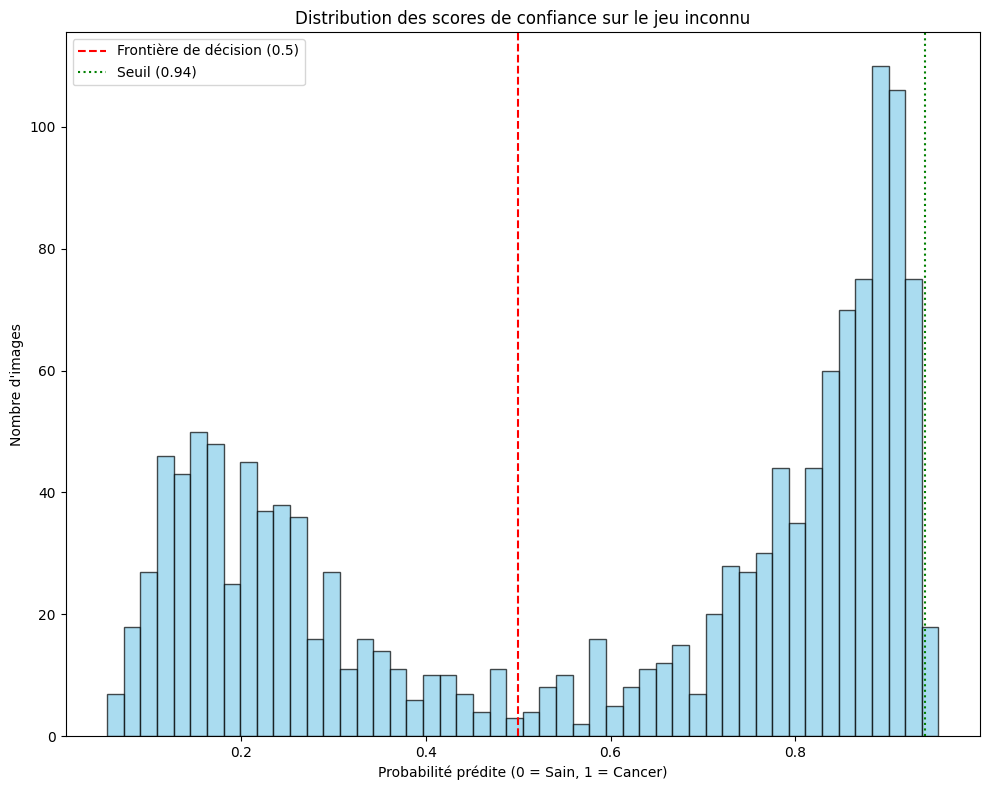

In [23]:
# from notebooks.utils.analyze_ssl import analyze_confidence
from notebooks.utils.plotting.make_model_plots import plot_confidence

new_trainer.model.load_state_dict(test_results['state_dict']) # Assure-toi que c'est la bonne clé
new_trainer.model.eval() 

all_unlabeled_probs = []
with torch.no_grad():
    for imgs, _, _ in uloader:
        logits = new_trainer.model(imgs.to(DEVICE))
        all_unlabeled_probs.extend(torch.sigmoid(logits).cpu().numpy().flatten())

all_unlabeled_probs = np.array(all_unlabeled_probs)

plot_confidence(
    probas=all_unlabeled_probs,# results['raw_data']['probs'],
    threshold=test_results['threshold'],#type:ignore
    stats=True,
    save_path=SAVE_PATH/"figures",
    title_save=f"distrib_sans_label_ssl_cluster_{ssl_with_cluster_config['model']}"
)

**Remarque pour compréhension personnelle**: Le nombre de pseudo label généré et stocké dans weak_labels.parquet repréente le nombre d'images trouvé respectant le threshold imposé et qui servira de set supplementaire d'entrainement a la même itération. C'est pourquoi il est normal de trouver 13 pseudo labels et voir que ce nombre ne correspond pas a la distribution puisque le modèle obtenu, s'est entrainé dessus. De plus, on a arrondi pour la représentation, le threshold et avec des bar elevés, on peut observer une différence avec le nombre de pseudo label généré ensuite.

In [24]:
matrix = plot_confusion_matrix(
    test_results['confusion_matrix'],
    save_path=SAVE_PATH/"figures",
    title_save=f"plot_confusion_matrix_ssl_cluster_{ssl_with_cluster_config['model']}"
)

plot_confusion_matrix_ssl_cluster_resnet18 sauvegardé dans /home/shipoz/Documents/OPENCLASSROOMS/P7/livrable_P7/datas/results/figures


Dans la grande boucle ssl, dès la deuxième itération on a notre meilleur modèle avec une amélioration du f2 (on pas vers 0.74) ainsi que de l'ece (0.13) et un PR AUC qui reste très bon (0.9). 

- (86) 6% des images sont incertaines
- (798) 57% des images sont potentiellement des cancers dont 13 avec une probabilité de 94% selon le modèle
- (522) 32% sont potentiellement sains avec une seule image dont la probabilité serait de 94%

Le modèle a été poussé pour prêter plus d'attention au cancer (F2, stratification...) c'est pourquoi il a plus confiance sur ses prédiction cancereuses et en trouve d'avantage. Le problème vient du jeu de validation (plus généralement du jeu de labellisé) qui est très faible et induit donc une forte variance des résultats et un etouffement par le pseudo labelling. 

In [ ]:
del ( test_results, all_unlabeled_probs, 
     trainer, model_classif, optimizer,
     new_model_classif, new_optimizer, new_trainer,
     udataset, uloader, test_loader, base_transform, 
     ssl_with_cluster_config, ssl_with_cluster_manager
    )
gc.collect()

234